In [0]:
!pip install dgl

     |████████████████████████████████| 3.0MB 3.5MB/s 


In [0]:
import networkx as nx # Networkx to load the graph
import torch as th # Pytorch as background of dg1
import dgl # Import dg1 to perform GCN
import dgl.function as fn # Function of dg1 to perform message reduce
import numpy as np # Import numpy for array 
import torch.nn as nn # Create pytorch module
import torch.nn.functional as F # Import relu
from tqdm import tqdm_notebook as tqdm # Tqdm to see the progress
import plotly.graph_objects as go # Use plotly to plot the graph
import pandas as pd # Use pandas to import data from csv
from math import log10 as log # Import log from math 
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit # Sklearn model train and test split
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score # Print output values
import matplotlib.pyplot as plt # plot the matplotlib graph
import seaborn as sns # Plot confusion matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
dataframe = pd.read_csv("/content/drive/My Drive/Retweet-Data+Sentiment.csv") # Import the data
edgeData = dataframe[["FollowerId","FolloweeId"]] # Get the edge data 
edgeList = [(row["FollowerId"],row["FolloweeId"]) for index,row in edgeData.iterrows()] # Create edge list

In [0]:
nodes = list(set(list(((np.array(edgeList)).flatten())))) # Nodes in the graph 
notImportantNodes = set(list(np.array(edgeList)[:,0]))- set(list(np.array(edgeList)[:,1])) # Nodes for which important nodes are not present

In [0]:
directedGraph = nx.DiGraph() # Create a directed graph
directedGraph.add_nodes_from(nodes) # Add nodes to graph
directedGraph.add_edges_from(edgeList) # Add edges to graph
directedGraph.remove_nodes_from(notImportantNodes) # Get all the non important nodes

In [0]:
newGraph = nx.convert_node_labels_to_integers(directedGraph,ordering="sorted") # Change node label to numberes

In [0]:
followeeData = (dataframe[["FolloweeId","No-Of-Followers","No-Of-Friends","Retweet-Count","Likes"]].groupby("FolloweeId").max()) # Get nodes features data
followeeData["No-Of-Friends"] = 1/(followeeData["No-Of-Friends"]+1) # Inverse of friends as features
followeeData["FFRatio"] = followeeData["No-Of-Friends"]*followeeData["No-Of-Followers"] # Follower and friend ratio 
followeeData["FFRatio"] = followeeData["FFRatio"]/followeeData["FFRatio"].max() # Get follower followee ratio between 1 and 0
followeeData["No-Of-Followers"] = followeeData["No-Of-Followers"]/followeeData["No-Of-Followers"].max() # Get no of followers between 0 and 1
followeeData["Retweet-Count"] = followeeData["Retweet-Count"]/followeeData["Retweet-Count"].max() # Get retweet count between 0 and 1
followeeData["Likes"] = followeeData["Likes"]/followeeData["Likes"].max() # Get likes count between 0 and 1
followeeData = followeeData.sort_index() # Sort the data based on followee id to match with the nodes from the new graph

In [0]:
features = followeeData.to_numpy() # Convert nodes features to numpy 
y = features.astype(np.float32) # Set features type as float 32 as dgl library for now only supports float 32
correctLabel = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0
               ,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
               ,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
               ,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0] # Truth label

In [0]:
x_train,x_test,y_train,y_test = train_test_split(list(range(200)), correctLabel, test_size=0.3,random_state=2) # train and test for sklearn

In [0]:
class Layer(nn.Module): # Create a layer in the dgl using pytoarch as the background
    def __init__(self, input, output): # Initialize the layer input and output
        super(Layer, self).__init__() # Call the parent implemenataionof module
        self.linear = nn.Linear(input, output) # Create a linear layer
        self.message = fn.copy_src(src='h', out='m') # Message function does only forward the features 
        self.reduce = fn.sum(msg='m', out='h') # Reduce function sum the features from his neighbour
        
    def forward(self,graph,feature): # Forward the features to the neighbours
        with graph.local_scope(): # Local scope ensures that the
            graph.ndata['h'] = feature # Set features for the nodes
            graph.update_all(self.message, self.reduce) # Update will update the feature for all nodes
            newFeatures = graph.ndata['h']  # This will return the updated features
            return self.linear(newFeatures) # return the features

In [0]:
class GCN2Layer(nn.Module): # Create layer for each node
    def __init__(self): #Initialize layer for eahc node
        super(GCN2Layer, self).__init__() # Call the supper for this layer
        self.gcn1 = Layer(5, 16) # Convert the dense input to 16 embedding 
        self.gcn2 = Layer(16, 2) # Convert this embedding to 2 influencer or not

    def forward(self, g, features): # This will update feature for each nodes
        x = F.relu(self.gcn1(g, features)) # Pass output of first layer from relu 
        x = self.gcn2(g, x) # send the output of second layer as output
        return x # Return the output

In [0]:
network = GCN2Layer() # Create the neural network
optimizer = th.optim.Adam(network.parameters(), lr=0.01) # Use adam as the neural net optimizer
followerGraph = dgl.DGLGraph(newGraph) # Create a dgl graph on which neural net is gonna run
# features = th.cat((th.eye(3356),th.tensor(y)),dim=1) # Concatenate features to end to get a new feature vector
features = th.tensor(y)
precision = []
recall = []
accuracy = []
f1_score1 = []
truthValues = (th.tensor(np.array(y_train))).view(-1).long() # Create a correct label for training tensor

for epoch in range(100): # Train network for number of epoches
    network.train() # Train the neural net
    answer = network(followerGraph, features) # Get label output from neural network
    softmaxAnswer = F.log_softmax(answer, 1) # Apply softmax to convert it into probability
    loss = F.nll_loss(softmaxAnswer[x_train], truthValues) # Calculate loss from ground truth
    optimizer.zero_grad() # Reinitialize gradient to zero
    loss.backward() # Backward propogration
    optimizer.step() # Step optimizer to new values
    finalAnswer = th.argmax(softmaxAnswer,dim=1) # Find the probable influence people based on probability
    answer = finalAnswer[x_test].detach().numpy() # Get numpy array
    precision += [precision_score(y_test,answer,average="macro")]
    recall += [recall_score(y_test,answer,average="macro")]
    f1_score1 += [f1_score(y_test,answer,average="macro")]
    accuracy += [accuracy_score(y_test,answer)]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [0]:
answer = finalAnswer[x_test].detach().numpy() # Get numpy array

In [0]:
# Printing macro and micro precision
print("Precision score macro : ",precision_score(y_test,answer,average="macro")) 
print("Precision score micro : ",precision_score(y_test,answer,average="micro"))

Precision score macro :  0.9622641509433962
Precision score micro :  0.9333333333333333


In [0]:
# Printing macro and micro recall
print("Recall score macro : ",recall_score(y_test,answer,average="macro"))
print("Recall score micro : ",recall_score(y_test,answer,average="micro"))

Recall score macro :  0.8181818181818181
Recall score micro :  0.9333333333333333


In [0]:
# Printing macro and micro f1_score
print("F1 score macro : ",f1_score(y_test,answer,average="macro"))
print("F1 score micro : ",f1_score(y_test,answer,average="micro"))

F1 score macro :  0.869281045751634
F1 score micro :  0.9333333333333333


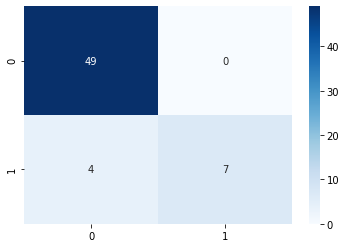

In [0]:
# Printing confusion matrix
sns.heatmap(confusion_matrix(y_test,answer), annot=True,cmap='Blues')

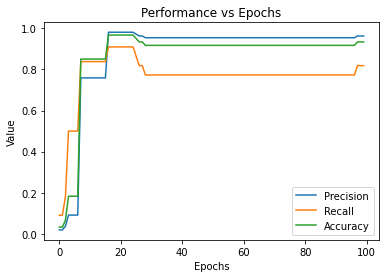

In [0]:
plt.plot(list(range(100)),precision,label="Precision")
plt.plot(list(range(100)),recall,label="Recall")
plt.plot(list(range(100)),accuracy,label="Accuracy")
plt.title("Performance vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()